<font size="10">Apply *TopicVelo* to scNT-seq (a metabolic labeling method) human haematopoiesis</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import mmwrite 
from scipy.sparse import csr_matrix, hstack

import tomotopy as tp
from tomotopy.coherence import Coherence
from tomotopy.utils import Corpus

import scvelo as scv
from scvelo.utils import get_transition_matrix

In [59]:
import cmasher as cmr

In [1]:
from TM_Utils import cells_to_documents, FastTopics_cluster_assign, TopicGeneFiltering, remove_U, TopicGenesQC, aggregate_clusters
from EmbedPlots import Plot_Topics, pl_TopTopicGenes, Plot_Genes, Plot_Velocity, comparison_heatmap, comparision_stacked_bar_plot, comparision_violin_plot, comparision_violin_plot_v2
from DistPlots import Experimental_JD_Plot, Burst_Simulation_JD_Plot, OS_Analytical_JD_Plot, ExpJD_Cluster_Focus_HeatMap
from TranscriptionSimulation import GeometricBurstTranscription, JointDistributionAnalysis, JointDistributionAnalysis_exp
from InferenceTools import Burst_Inference_Gene, KLdivergence, topic_threshold_heuristic_plot, Burst_Inference
from TransitionMatrix import Combined_Topics_Transitions, get_cells_indices, velocity_graph, rescale_and_smooth, terminal_distribution, mfpt_to_targets
from deeptime.markov.tools.analysis import stationary_distribution, mfpt

In [289]:
import matplotlib.colors as colors


def comparision_violin_plot_v2(adata, keys, categories,
                            groupby='cell_type',
                            key_spacing = 1, groupby_spacing=2.75, figsize=(15,5),
                            edgecolor = 'black', color_by = 'cell_type',
                            fontsize=16, xlabels=None, ylabel=None, title=None,
                            qs=[25,75], ylim=None, savefile=None):
    '''
    parameters
    ---------------
    adata: 
        (Adata) object containing scRNAseq information
    keys: 
        (list of str) adata.obs that contains the data 
    categories: 
        (list of str) the annotations within a group to be used
    
    groupby: 
        (str) the name of grouping used to divide up the values in keys
    key_spacing: 
        (float) spacing between violins within each key
    groupby_spacing: 
        (float) spacing between violins among keys (between categories)
    
    
    
    returns
    ---------------
    None
    
    '''
    from matplotlib.pyplot import violinplot
    
    
    n_keys = len(keys)
    n_categories = len(categories)

    n_violins = int(len(keys)*len(categories))
    
    #positions of the violins
    ps = np.linspace(0, key_spacing*(n_categories-1), num=n_categories)
    positions = [ps]
    tick_ps = [np.mean(ps)]
    for i in range(1, n_keys):
        new_ps = ps+i*groupby_spacing
        positions.append(new_ps)
        tick_ps.append(np.mean(new_ps))
    positions = np.array(positions).flatten()
    
    #extract data for each categories->key
    data = []
    medians=[]
    qs1 = []
    qs2 = []
    
    for i in range(n_keys):
        for j in range(n_categories):
            to_add = adata.obs[keys[i]].to_numpy()[np.where(adata.obs[groupby]==categories[j])[0]]
            data.append(to_add)
            medians.append(np.median(to_add))
            qs1.append(np.percentile(to_add, qs[0]))
            qs2.append(np.percentile(to_add, qs[1]))
    data=np.array(data)
    
    #set dimension
    fig, ax = plt.subplots(figsize=figsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    violin_plot = ax.violinplot(data, positions, widths=0.85, showmeans=False, showmedians=False, showextrema=False)
    
    ax.vlines(positions, qs1, qs2, color='white', linestyle='-', lw=2.5, zorder=1)
    ax.scatter(positions, medians, marker='o', color='k', zorder=2, s=15)
    
    facecolors = []
    all_categories = list(adata.obs[color_by].cat.categories.to_numpy())
    ccs = color_by+'_colors'
    colors = np.array(adata.uns[ccs])
    for c in categories:
        if c in all_categories:
            #print(colors[all_categories.index(c)])
            facecolors.append(colors[all_categories.index(c)])
        else:
            facecolors.append('#000000')
    
    for i, pc in enumerate(violin_plot["bodies"], 0):
        pc.set_facecolor(facecolors[int(i%n_categories)])
        pc.set_edgecolor(edgecolor)
    
    #add x ticks and labels
    ax.set_xticks(tick_ps)
    if xlabels:
        ax.set_xticklabels(xlabels, fontsize=fontsize)
    else:
        ax.set_xticklabels(keys, fontsize=fontsize)
    #add y labels
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.legend(categories, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)
    plt.ylim(ylim)
    plt.tight_layout()
    
    
    if savefile:
        plt.savefig(savefile, format='svg', dpi=300, transparent=True)
    else:
        plt.show()
        

<font size="6">read the data which was provided in the *dynamo* paper</font>

In [2]:
#please modify the home_path accordingly 
home_path = '/Users/frankgao/Documents/Burst_RNAVelocity/TopicVelo_0.1'
adata = scv.read(home_path+'/data/scNT-seq_Human_haematopoiesis/hsc_hv2000.h5ad')

adata.var_names_make_unique
adata.var.index = adata.var['gene_name'].tolist()

In [3]:
adata_2 = scv.read(home_path + '/data/scNT-seq_Human_haematopoiesis/HSC.h5ad')

In [54]:
#get transition matrix from the dynamo paper
#use the provided transition matrix
adata.obsp['dynamo_T'] = adata_2.obsp['cosine_transition_matrix']

In [55]:
#recompute the transition matrix
scv.tl.velocity_graph(adata_2, vkey='velocity_alpha_minus_gamma_s', xkey='M_t')
adata.obsp['dynamo_T'] = get_transition_matrix(adata_2, vkey='velocity_alpha_minus_gamma_s')

computing velocity graph (using 1/12 cores)
    finished (0:00:14) --> added 
    'velocity_alpha_minus_gamma_s_graph', sparse matrix with cosine correlations (adata.uns)


<font size="10">Preprocessing</font>
<br>
<font size="6">We create a matrix ```S_U``` by stacking the spliced and unspliced count matrix and save this matrix and the assoicated gene names</font>

In [4]:
S_U = csr_matrix(hstack([adata.layers['raw_spliced'], adata.layers['raw_unspliced']]), dtype=np.int32)

In [5]:
genes_S = adata.var['gene_name'].to_list()
genes_U = [g+'_U' for g in genes_S]
gene_names = np.hstack((genes_S, genes_U))

In [ ]:
mmwrite('fastTopics/scNT_HH_filtered_SU_Counts', S_U)
pd.DataFrame(gene_names).to_csv("fastTopics/scNT_HH_filtered_SU_Genes_names.csv")
pd.DataFrame(adata.obs_names.to_list()).to_csv("fastTopics/scNT_HH_filtered_SU_Cells_names.csv")

<font size="10">Analysis with scVelo</font>
<br>
<font size="6">We use the stochastic model to compute the velocity and the associated transition matrix.</font>

In [6]:
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity_graph(adata, vkey='scvelo_stochastic_velocity')

computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:01) --> added 
    'scvelo_stochastic_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'scvelo_stochastic_velocity_umap_ori', embedded velocity vectors (adata.obsm)


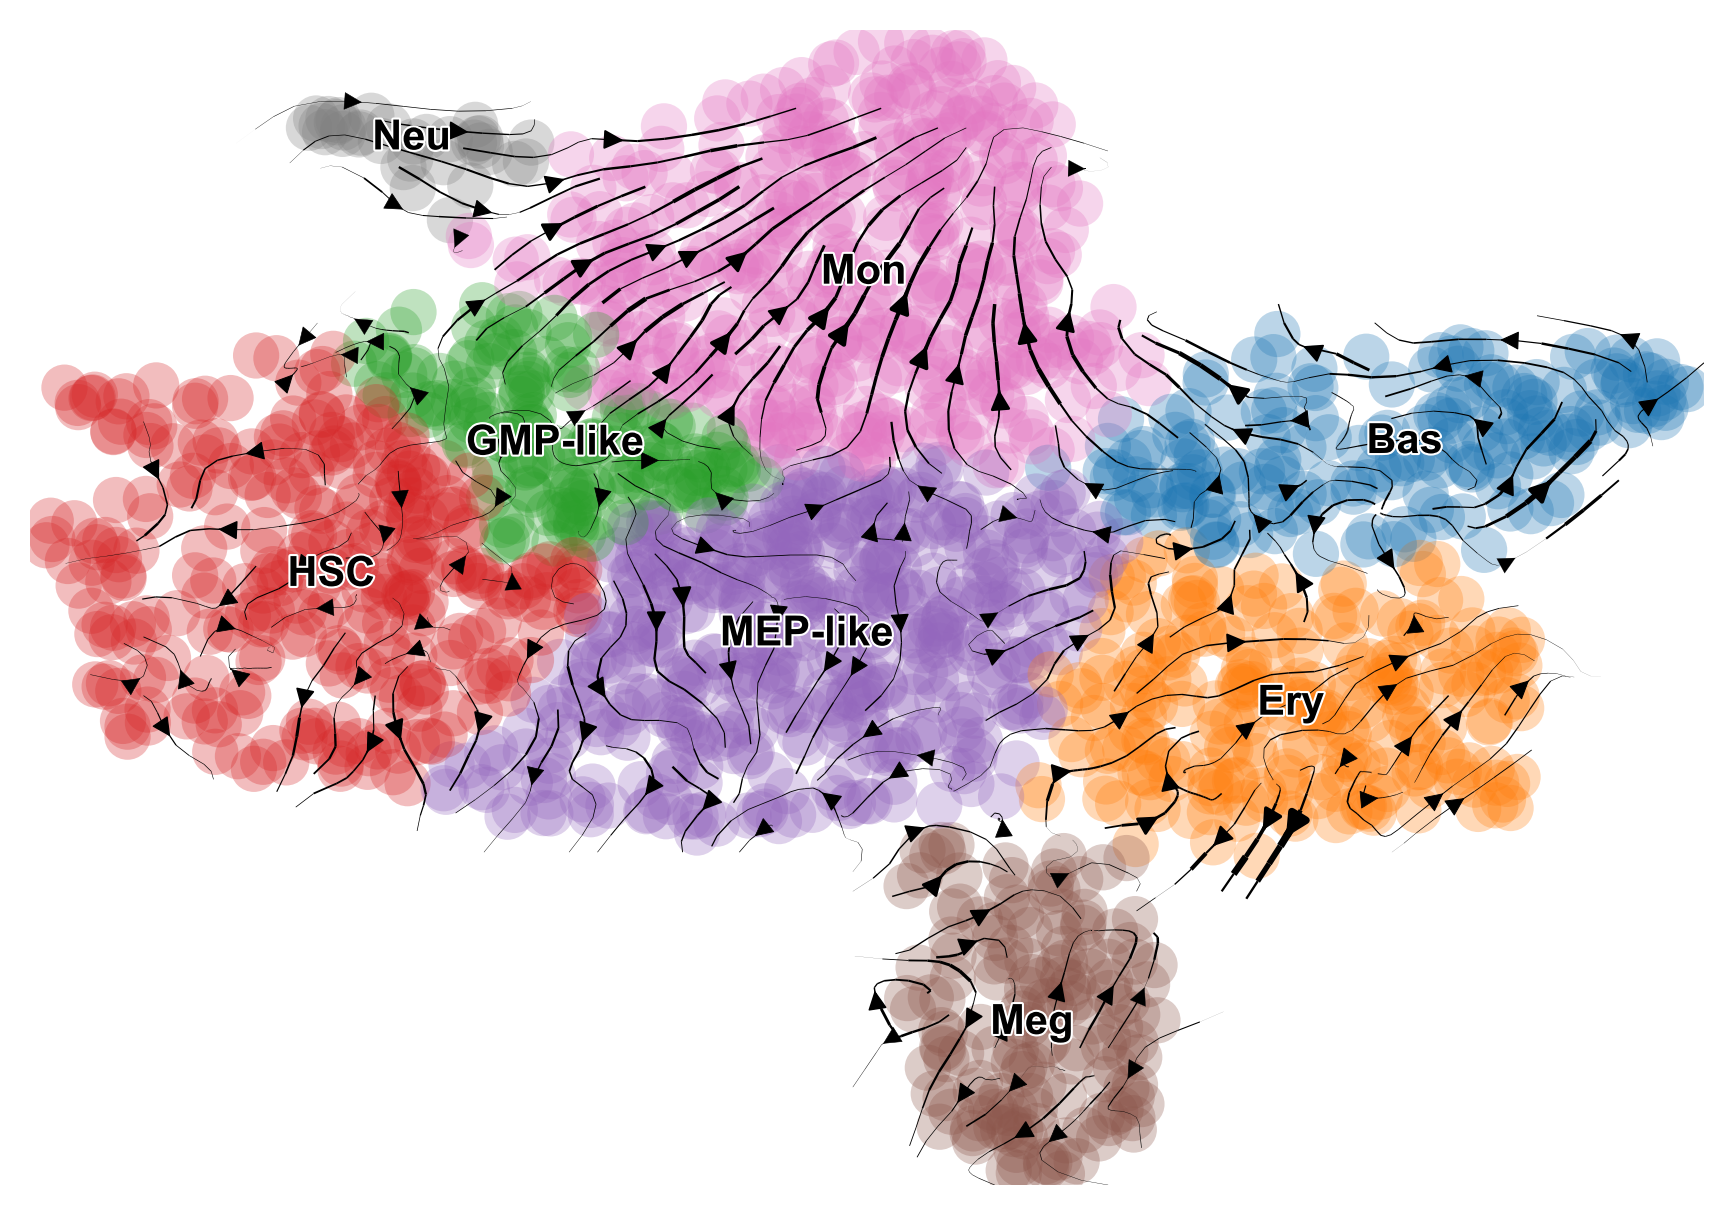

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap_ori',dpi=100, 
                                 color='cell_type', vkey='scvelo_stochastic_velocity', legend_loc='on data', title = '', figsize=(7.2, 5))

<font size="10">Identify optimal number of topics with Tomotopy</font>
<br>
<font size="6">We run topic modeling over a range of topic numbers for 100 reptitions each then compute a coherence measures $c_V$ to determine a reasonable range for the number of topics</font>

In [ ]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
reps = 10

In [ ]:
lda_models = np.zeros((len(ks), reps), dtype=object)
coherence = np.zeros((len(ks), reps))

In [ ]:
corpus = Corpus()
for i in range(adata.n_obs):
    corpus.add_doc(cells_to_documents(S_U[i,:].A[0], gene_names))

In [ ]:
for k in range(len(ks)): 
    for r in range(reps):
        #perform topic modeling for a variety of topic numbers
        lda = tp.LDAModel(k=ks[k], rm_top=0)
        lda.burn_in = 50
        lda.add_corpus(corpus)
        #may want to change the parallel parameters
        lda.train(iter=150, parallel=4)
        lda_models[k,r] =  lda

        coh_kr = Coherence(lda, coherence='c_v')
        coherence[k,r] = coh_kr.get_score()

In [ ]:
coherence_means = np.mean(coherence, axis=1)
coherence_err = np.std(coherence, axis=1)
plt.errorbar(ks, coherence_means,  yerr=coherence_err, fmt='o-')
#plt.ylabel(r'$C_{v}$', size=26)
plt.ylabel('Coherence', size=16)
plt.xlabel('Number of Topics', size=16)

<font size="6">From the result above we notice for more than 8 topics, the mean of $C_v$ across 100 reptitions stablizes around 0.4. We do not want to overfit the model so we chose K=8 for further analysis. </font>
<br>
<font size="6">Now we perform topic modeling in *R* using *FastTopics* which can perform advanced differential expression analysis. Please see the *R* markdown file. </font>


<font size="6">After we finished runing the *R* Markodown file, the topic weights and differential expression analysis are saved locally. We load the topic weights of cells and add the topic weights to the adata object. Then we visulize the topic weights on umap.</font>

In [7]:
#load the cellweights from fast topics and skip header and first column which are just junk
cellWeights = np.genfromtxt(home_path+'/FastTopics/scNT_HH/scNT_HH_fastTopics_fit_CellWeights.csv', delimiter=",", skip_header=1)[:,1:]

In [8]:
#get topic number
K = cellWeights.shape[1]
print(cellWeights.shape)

(1947, 8)


In [9]:
#add topic weights
FastTopics_cluster_assign(adata, cellWeights, t_type = 'fastTopics')

In [ ]:
#plot the topics
for i in range(K):
    Plot_Topics(adata, str(i), t_type = 'fastTopics', basis='umap_ori', savefile = True, point_size=10, shrink=0.5, 
                labelsize=20, cbar_save='topic'+str(i)+'weights.svg')

<font size="6">load the differential expression analysis from *FastTopics*. Select topic genes then add them to the adata object for later access</font>

In [10]:
#load the cellweights from fast topics and skip header and first column which are just junk
de_postmean = np.genfromtxt('FastTopics/scNT_HH/scNT_HH_de_postmean.csv', delimiter=",", skip_header=1)[:,1:]
de_lfsr = np.genfromtxt('FastTopics/scNT_HH/scNT_HH_de_lfsr.csv', delimiter=",", skip_header=1)[:,1:]
de_z = np.genfromtxt('FastTopics/scNT_HH/scNT_HH_de_z.csv', delimiter=",", skip_header=1)[:,1:]

In [11]:
#select the topic genes
ttgs, ttg_up, ttg_down = TopicGeneFiltering(de_postmean, de_lfsr, 
                                            lfc_up_th = 0.5, lfc_down_th=-0.5, 
                                            lfsr_up_th = 0.001, lfsr_down_th = 0.001)

In [12]:
top_genes = remove_U(ttgs, gene_names)
top_genes_up = remove_U(ttg_up, gene_names)
top_genes_down = remove_U(ttg_down, gene_names)

#show how many topic genes have a positive log-fold changes in each topic
for ttgs_up_k in top_genes_up:
    print(len(ttgs_up_k))
print('\n')
for ttgs_k in top_genes:
    print(len(ttgs_k))

78
37
24
92
54
18
30
20


78
43
32
94
57
20
33
26


In [13]:
adata.uns['top_genes'] = top_genes

<font size="6">Let's make a few bar plots to look at genes with the highest log-fold changes in topics 1, 3, 5, 6</font>

In [ ]:
ttg_names1, log_fold_change_ttg1, z_ttg1 = pl_TopTopicGenes(10, 1, gene_names, ttg_up, de_postmean, de_z,  save='scNT_HH_k=8_t1_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    
ttg_names3, log_fold_change_ttg3, z_ttg3  = pl_TopTopicGenes(10, 3, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t3_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))
ttg_names5, log_fold_change_ttg5, z_ttg5  = pl_TopTopicGenes(10, 5, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t5_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    
ttg_names6, log_fold_change_ttg6, z_ttg6 = pl_TopTopicGenes(10, 6, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t6_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    

<font size="6">Plot some examples expression of topic genes. We will plot the size-normalized expression on the log-scale in the following order</font>
<br>
<font size="6">For topic 1 we plot *HDC*</font>
<br>
<font size="6">For topic 3 we plot *PLEK*</font>
<br>
<font size="6">For topic 5 we plot *PCNA*</font>
<br>
<font size="6">For topic 6 we plot *RPL9*</font>

In [ ]:
Genes_to_plot = ['HDC', 'PLEK', 'PCNA', 'RPL9']
for gene in Genes_to_plot:
    Plot_Genes(adata, gene, 'spliced', log_scale = True, basis='umap_ori', savefile = gene+'_spliced.png', expr_percentile = 100, s=10, shrink=0.3, labelsize=20, cbar_save=gene+'_spliced'+'_colorbar'+'.svg')

<font size="6">*HDC* is strongly associated with basophils</font>
<br>
<font size="6">*PLEK* is connected to megakaryocytes</font>
<br>
<font size="6">*PCNA*, *RPL9* are ubiquitously expressed and topics 5 and 6 are correlated with minichromosome (MCM-genes) and ribsome(RPL-genes) so we do not use topics 5 and 6 for downstream analysis.</font>

<font size="6">Now Let's see how *TopicVelo*'s use of topic modeling helps zoom into the dynamics of key genes</font>

In [ ]:
gene = 'F13A1'
topic_to_focus = '3'
ExpJD_Cluster_Focus_HeatMap(adata, gene, clusters= 'fastTopics_cluster', focus = topic_to_focus, vmin=1e-3, x_cutoff=10)

<font size="6">We observed trend of upgregulations in the distribution over topics which is not seen in the distribution over all cells</font>

<font size="6">The following code demonstrates the joint distribution recovery process of F13A1 in topic 3 via one-state model vs. the burst model</font>

In [ ]:
#create a subset of only cells whose highest topic weight is topic 3
ts = [3]
ttc_indices = []
for k in ts:
    ttc_indices.extend([i for i in range(adata.n_obs) if adata.obs['fastTopics_cluster'][i] == k])
adata_subset_3 = adata[ttc_indices]

<font size="6">For the one state model, we showed the maximum liklihood estimation parameters are $\alpha'=<u>$ and $\gamma' = \frac{<u>}{<s>}$. 
<br>
    For the burst model, we use our numerical inference scheme to estimate the MLE parameters.</font>

In [ ]:
#analytical MLE for one state
alpha = np.mean(adata_subset_3[:,gene].layers['raw_unspliced'])
gamma = alpha/np.mean(adata_subset_3[:,gene].layers['raw_spliced'])

#numerical estimate MLE with the burst model 
InferredParameters, minKL = Burst_Inference_Gene(adata_subset_3, gene, xkey = 'raw_spliced')

In [ ]:
#Joint distribution for one-state
OS_JD = OS_Analytical_JD_Plot(gene, (alpha, gamma), 6, 10, vmax = 1, vmin = 1e-3, log_scale_cb = True, save = 'F13A1_OS_topic3.svg')

#Joint distribution for burst model
Burst_sim_JD = Burst_Simulation_JD_Plot(gene, InferredParameters, x_cutoff = 10, y_cutoff = 6, vmax = 1, vmin = 1e-3, log_scale_cb = True, save = 'F13A1_burst_topic3.svg')

#plot the experimental distribution again
F13A1_t3_JD = Experimental_JD_Plot(adata_subset_3, gene, xkey = 'raw_spliced', ukey='raw_unspliced', x_cutoff = 10, y_cutoff = 6, vmin=1e-3, vmax=1, log_scale_cb = True, save = 'F13A1_EXP_JD_Topic.svg')

In [ ]:
#KL divergence between the one state model and observed
print(np.log(KLdivergence(OS_JD, F13A1_t3_JD)))

#KL divergence between the burst model and observed
print(np.log(KLdivergence(Burst_sim_JD, F13A1_t3_JD)))

<font size="6">We see the recovery using the burst model matches the experimental distribution more closely than the one-state model especially in the lowly expressed regime.</font>

<font size="10">Choosing topic threshold</font>
<br>
<font size="6">Let's use the heuristics based on the KL divergence of topic genes with the highest log-fold changes</font>

<font size="10">TopicVelo integrates the transition matrices</font>
<br>
<font size="6">We will use previously determined threshold on the topics relevant to differentitaion</font>

In [14]:
topics = [0,1,3,4,7]
topics_to_use_percentile_thresholds = [35, 35, 35, 35, 35]

In [15]:
combined_TM, ttc_indices = Combined_Topics_Transitions(adata, topics = topics, velocity_type = 'burst', 
                                                            recompute = False, recompute_matrix = False, steady_state_perc = 95,
                                                            topic_weights_th_percentile = topics_to_use_percentile_thresholds, 
                                                            subset_save_prefix = 'scNT_HH_') 

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
The correlation threshold has been reduced to -0.8483.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)
    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'vel

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_ori', embedded velocity vectors (adata.obsm)


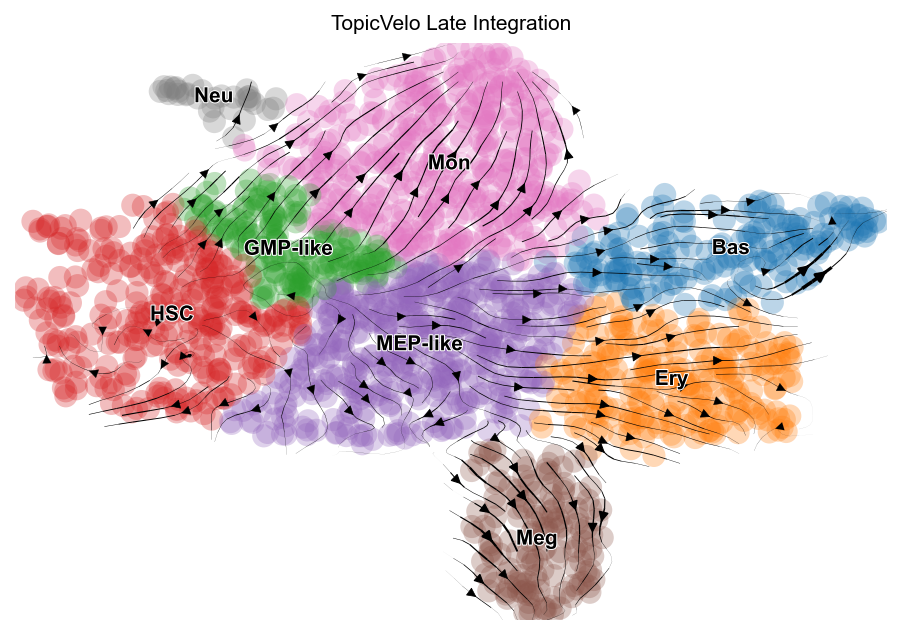

In [16]:
#compute embedded velocity vectors from TopicVelo's integrated transition matrix
topicVelo_embedding = scv.tl.velocity_embedding(adata, basis='umap_ori', T=combined_TM)
scv.pl.velocity_embedding_stream(adata, basis='umap_ori', V=topicVelo_embedding, dpi=150, color='cell_type', legend_loc='on data',
                                 title = 'TopicVelo Late Integration', figsize=(7.5, 5))

<font size="6">The streamline from *TopicVelo*, as opposed to *scVelo* captures majority of differentiation lineages and agrees much better with *dynamo* (Please see main Figure 3 a, b, c for a side-by-side comparision.</font>

<font size="6">Compute Stationary distribution, mean first passage time and hitting probability of scVelo vs topicVelo </font>

In [21]:
adata.obsp['topicVelo_T'] = combined_TM
adata.obs['topicVelo_stationary_distribution'] = stationary_distribution(adata.obsp['topicVelo_T'], check_inputs=False)

In [24]:
adata.obsp['scvelo_stochastic_T'] = get_transition_matrix(adata, vkey='scvelo_stochastic_velocity')
adata.obs['scvelo_stochastic_stationary_distribution'] = stationary_distribution(adata.obsp['scvelo_stochastic_T'], check_inputs=False)

In [56]:
adata.obs['dynamo_stationary_distribution'] = stationary_distribution(adata.obsp['dynamo_T'], check_inputs=False)

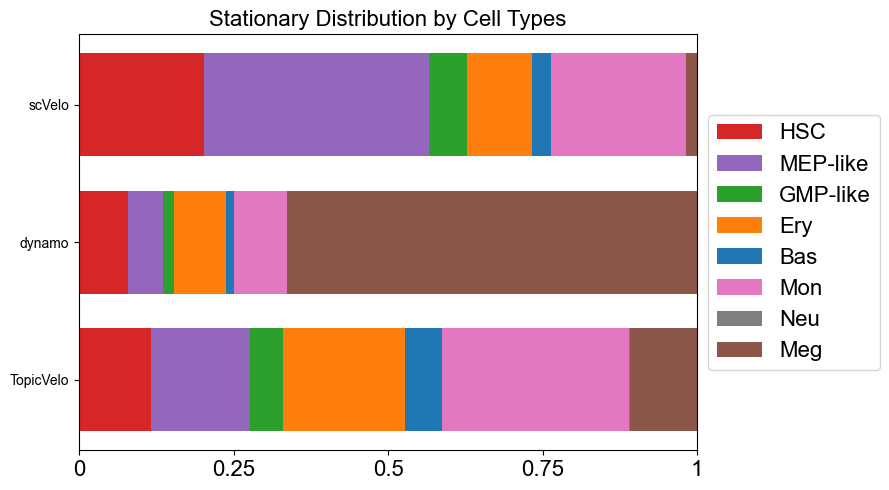

In [69]:
comparision_stacked_bar_plot(adata, ['scvelo_stochastic_stationary_distribution', 'dynamo_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo', 'dynamo', 'TopicVelo'], groupby='cell_type',
                             categories=['HSC', 'MEP-like', 'GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                        fontsize=16,  title='Stationary Distribution by Cell Types',
                        figsize=(9,5), savefile='stat_dist.svg')

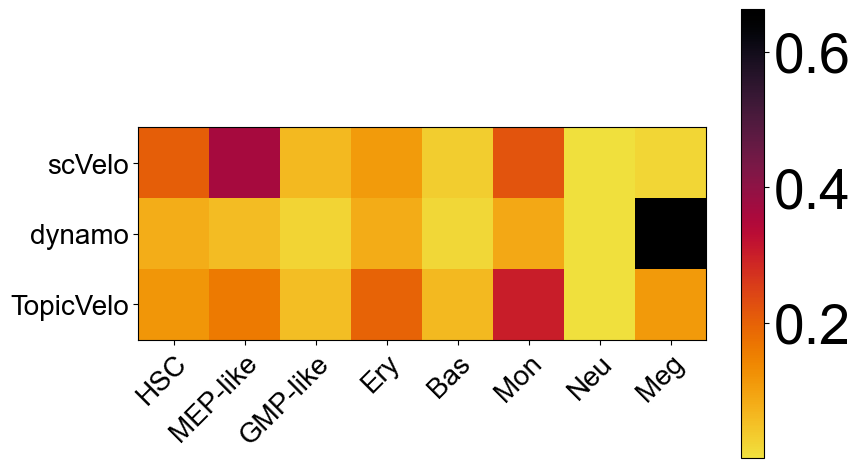

In [70]:
comparison_heatmap(adata, ['scvelo_stochastic_stationary_distribution', 'dynamo_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo','dynamo','TopicVelo'], groupby='cell_type',
                             categories=['HSC', 'MEP-like', 'GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                        fontsize=20,  title=None, labelsize=40, cmap=cmr.ember_r,
                        figsize=(9,5), savefile='stat_dist_hm.svg')

In [38]:
#choose destination cells for the mfpt analysis
#cells that have very high meg characteristics were chosen 
dest_cells, _ = get_cells_indices(adata, [3], topic_weights_th_percentile = 95)
dest_cells = np.unique(np.array(dest_cells).flatten())

In [65]:
adata.obs['topicVelo_mfpt_3'] = mfpt(adata.obsp['topicVelo_T'], dest_cells)
rescale_and_smooth(adata, 'topicVelo_mfpt_3')

adata.obs['scVelo_mfpt_3'] = mfpt(adata.obsp['scvelo_stochastic_T'], dest_cells)
rescale_and_smooth(adata, 'scVelo_mfpt_3')

adata.obs['dynamo_mfpt_3'] = mfpt(adata.obsp['dynamo_T'], dest_cells)
rescale_and_smooth(adata, 'dynamo_mfpt_3')

In [40]:
#Put other cell types into their own things
aggregate_clusters(adata, 'cell_type', ['HSC', 'MEP-like', 'Ery', 'Meg'], 'cell_type_agg', other_names='others')

In [74]:
adata.obs['cell_type_agg']

barcode
CCACAAGCGTGC-JL12_0      others
CCATCCTGTGGA-JL12_0         Meg
CCCTCGGCCGCA-JL12_0      others
CCGCCCACCATG-JL12_0      others
CCGCTGTGTAAG-JL12_0    MEP-like
                         ...   
GTGAACCTGTGA-JL12_1    MEP-like
GTGAGACAATAC-JL12_1    MEP-like
GTGATATTGACC-JL12_1    MEP-like
GTGCCGCGACAA-JL12_1      others
GTGTGCATTCCT-JL12_1         Ery
Name: cell_type_agg, Length: 1947, dtype: object

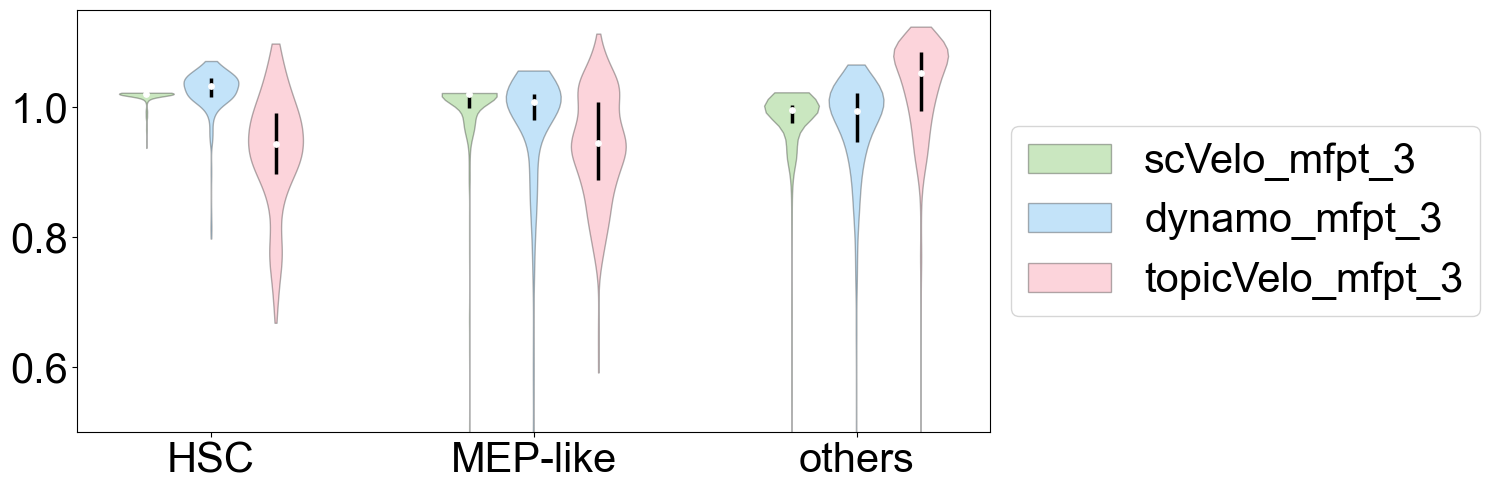

In [75]:
comparision_violin_plot(adata, ['scVelo_mfpt_3', 'dynamo_mfpt_3', 'topicVelo_mfpt_3'], groupby='cell_type_agg', 
                    categories=['HSC','MEP-like', 'others'],groupby_spacing=5,
                    title=None, fontsize=30,
                    figsize=(15,5), ylim=[0.5,1.15], savefile='mfpt_3_p1.svg')

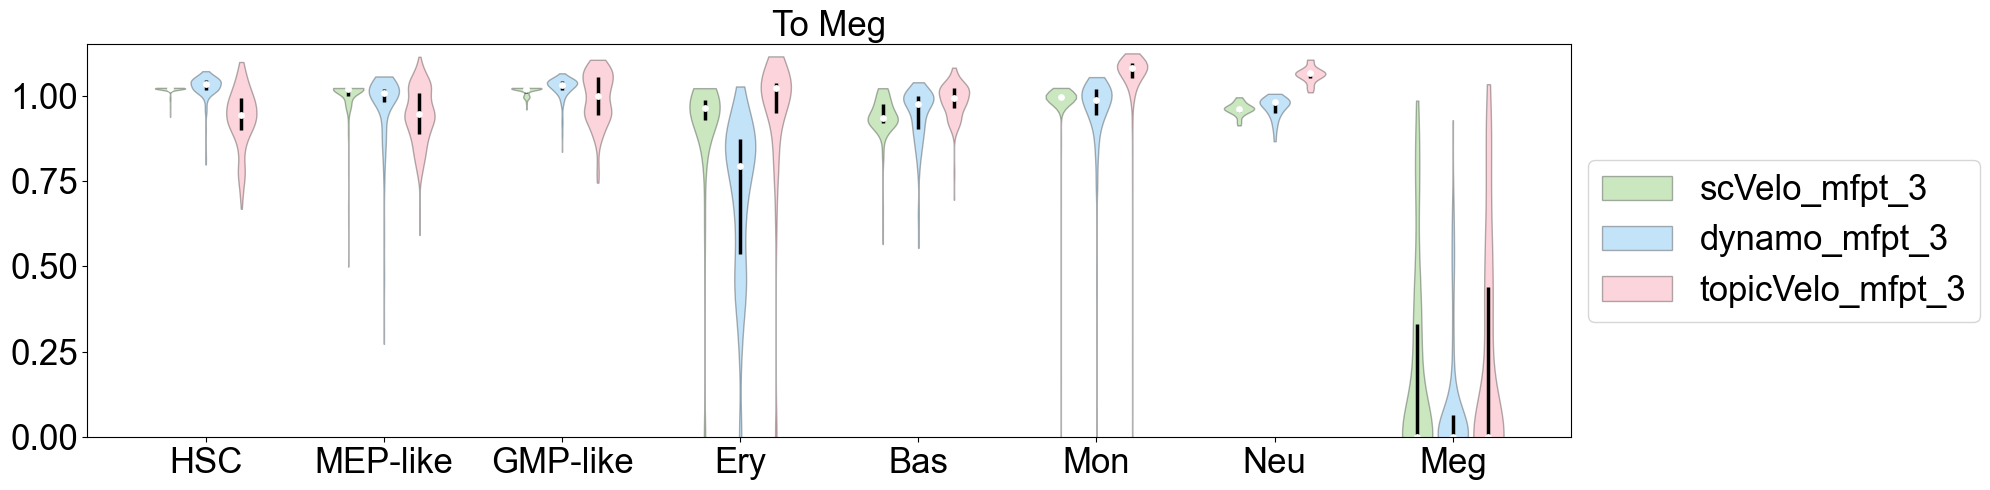

In [149]:
comparision_violin_plot(adata, ['scVelo_mfpt_3','dynamo_mfpt_3','topicVelo_mfpt_3'], groupby='cell_type', 
                    categories=['HSC','MEP-like','GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                    title='To Meg', fontsize=25,groupby_spacing=5,
                    figsize=(20,5), ylim=[0, 1.15], savefile='mfpt_3_all.svg')

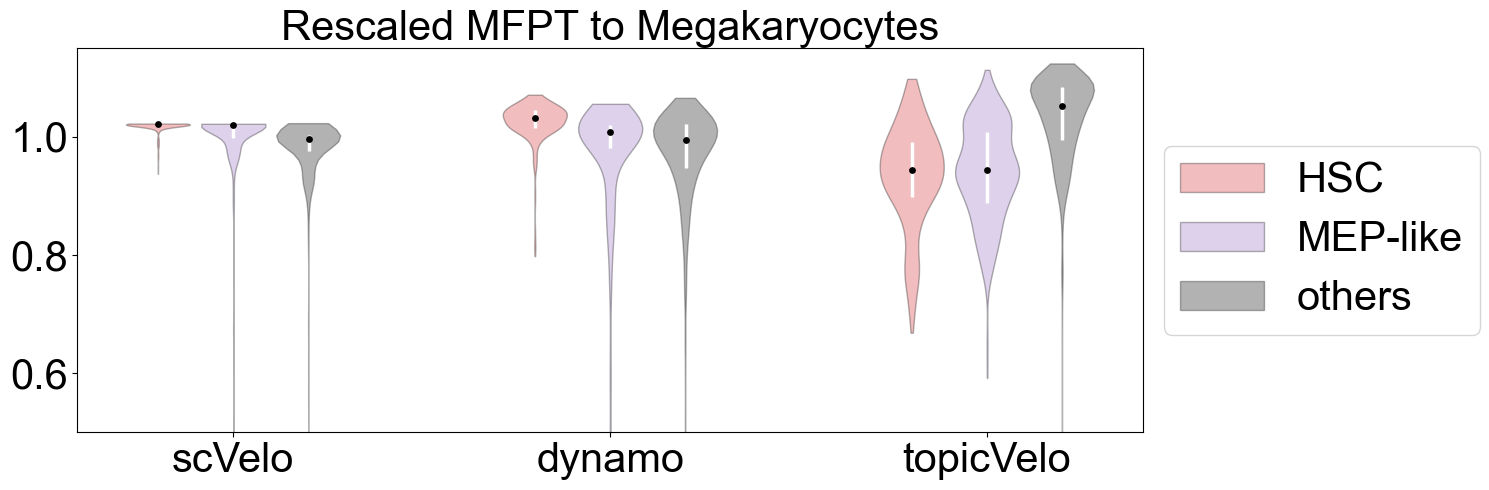

In [291]:
comparision_violin_plot_v2(adata, ['scVelo_mfpt_3', 'dynamo_mfpt_3', 'topicVelo_mfpt_3'], ['HSC','MEP-like', 'others'],
                           groupby='cell_type_agg', xlabels=['scVelo','dynamo','topicVelo'],
                           groupby_spacing=5, title='Rescaled MFPT to Megakaryocytes',fontsize=30,
                           figsize=(15,5), ylim=[0.5,1.15], savefile='mfpt_3_p1.svg')

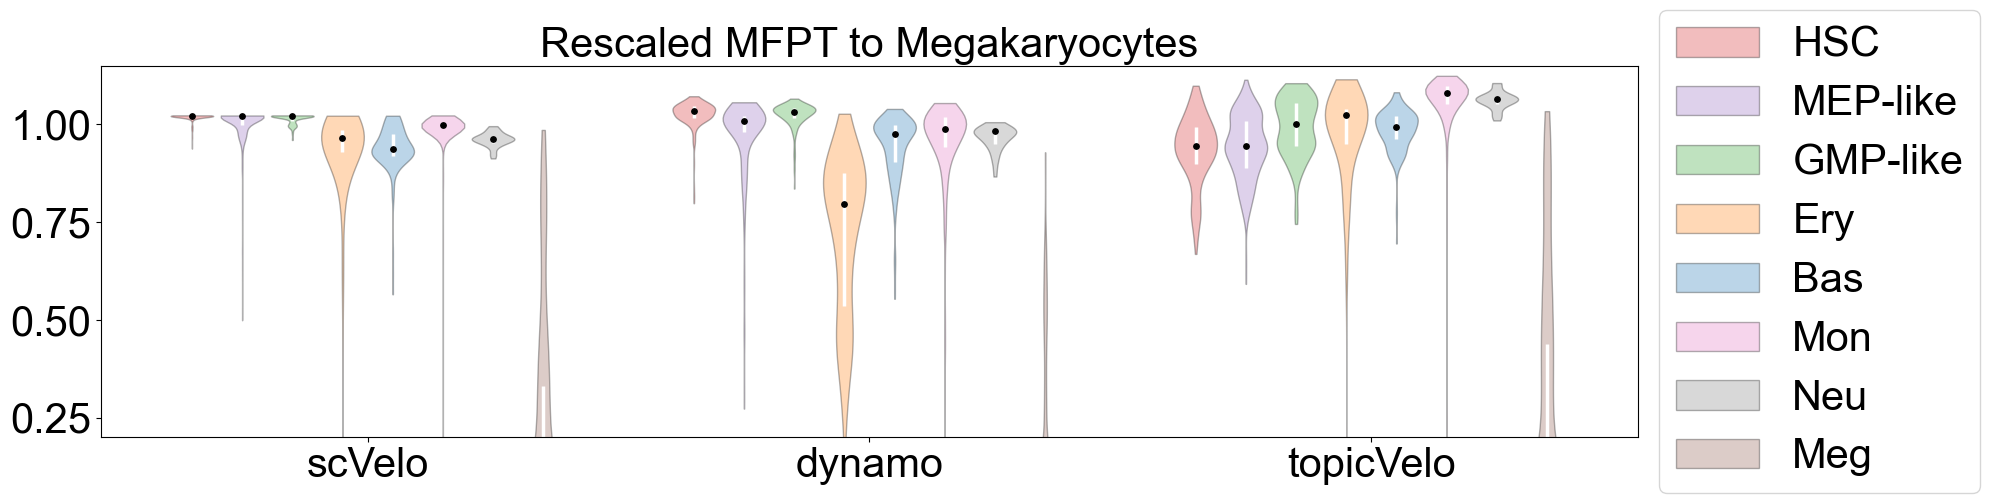

In [297]:
comparision_violin_plot_v2(adata, ['scVelo_mfpt_3', 'dynamo_mfpt_3', 'topicVelo_mfpt_3'], 
                           ['HSC','MEP-like','GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                           groupby='cell_type', xlabels=['scVelo','dynamo','topicVelo'],
                           groupby_spacing=10, title='Rescaled MFPT to Megakaryocytes',fontsize=30,
                           figsize=(20,5), ylim=[0.2,1.15], savefile='mfpt_3_all.svg')

<font size="6">Permutation test to get statistical significance between the distribution of mfpt</font>

In [224]:
def permutation_test(
    adata, 
    k_cluster, 
    k_test,
    k_null, 
    k_compare_on,
    n_resamples = 9999):
    """
    Compute empirical p-value on the means between a test_distribution and the null (background) distribution
    
    Args:
        adata (Anndata):
            Anndata object.
        k_cluster (str):
            key to the cluster column in adata.obs DataFrame.
        k_test (str): 
            group in adata.obs that is used as the test distribution (alternative hypothesis)
        k_null (str): 
            group in adata.obs that is used as the null distribution (null hypothesis)
        k_compare_on (str):
            key to the data in adata.obs to extract two distributions
        n_resamples (int):
            number of subsamples drawn from k_null
    
    Returns:
        p_val (float):
            empirical p-value
    """
    test_dist = adata.obs[k_compare_on][np.where(adata.obs[k_cluster]==k_test)[0]]
    null_dist = adata.obs[k_compare_on][np.where(adata.obs[k_cluster]==k_null)[0]]
    
    def run_permutation_test(pooled,test_size,null_size):
        np.random.shuffle(pooled)
        test_star = pooled[:test_size]
        null_star = pooled[-null_size:]
        return test_star.mean() - null_star.mean()
    
    pooled = np.hstack([test_dist,null_dist])
    delta = abs(test_dist.mean() - null_dist.mean())
    
    estimates = np.abs(np.array([run_permutation_test(pooled,test_dist.size,null_dist.size) for i in range(n_resamples)]))
    #print(estimates, delta)
    
    
    p_val = (len(np.where(estimates >= delta)[0])+1)/(n_resamples+1)
    #hat_asl_perm = 1.0 - (float(diff_count)/float(n_resamples))

    
    return p_val
    

In [298]:
for k_mfpt in ['scVelo_mfpt_3', 'dynamo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'HSC', permutation_test(adata, 'cell_type_agg', 'HSC', 'others', k_mfpt))

scVelo_mfpt_3 HSC 0.0001
dynamo_mfpt_3 HSC 0.0001
topicVelo_mfpt_3 HSC 0.0001


In [300]:
for k_mfpt in ['scVelo_mfpt_3', 'dynamo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'MEP-like', permutation_test(adata, 'cell_type_agg', 'MEP-like', 'others', k_mfpt))

scVelo_mfpt_3 MEP-like 0.0001
dynamo_mfpt_3 MEP-like 0.883
topicVelo_mfpt_3 MEP-like 0.0001


<font size="6">Compute relative flux between known transitions </font>

In [180]:
def relative_flux_correctness(
    adata, 
    k_cluster, 
    k_transition_matrix, 
    cluster_transitions,
    normalize=False):
    """Compute Birdirectional Flux and Relative Flux Direction Correctness Score (A->B) on the transition matrix
    
    Args:
        adata (Anndata): 
            Anndata object.
        k_cluster (str): 
            key to the cluster column in adata.obs DataFrame.
        k_transition_matrix (str): 
            key to the transition matrix in adata.obs.
        cluster_transitions (list of tuples("A", "B")): 
            pairs of clusters has transition direction A->B
        normalize:
        
    Returns:
        rel_flux (dict):
            relative flux from A->B
        flux (dict): 
            forward and reverse flux between A and B
    """
    flux = {}
    rel_flux = {}
    for A, B in cluster_transitions:
        A_inds = np.where(adata.obs[k_cluster] == A)[0]
        B_inds = np.where(adata.obs[k_cluster] == B)[0]
        A_to_B = 0
        for b in B_inds:
            A_to_B += np.sum(adata.obsp[k_transition_matrix][A_inds,b])  
        B_to_A = 0
        for a in A_inds:
            B_to_A += np.sum(adata.obsp[k_transition_matrix][B_inds,a])  
        if normalize: 
            flux[(A, B)] = A_to_B/len(A_inds)
            flux[(B, A)] = B_to_A/len(B_inds)
            rel_flux[(A,B)] = flux[(A, B)]-flux[(B, A)]
        else:
            flux[(A, B)] = A_to_B
            flux[(B, A)] = B_to_A
            #rel_flux[(A,B)] = flux[(A, B)]/(flux[(A, B)]+flux[(B, A)])
            rel_flux[(A,B)] = (flux[(A, B)]-flux[(B, A)])/(flux[(A, B)]+flux[(B, A)])
    
    adata.uns[k_transition_matrix + '_rel_flux'] = rel_flux
    adata.uns[k_transition_matrix + '_flux'] = flux
    
    return rel_flux, flux

In [309]:
cluster_transitions = [('HSC','GMP-like'), ('HSC','MEP-like'), 
                       ('GMP-like','Mon'),
                       ('MEP-like','Ery'), ('MEP-like','Meg')]
transition_matrices = ['dynamo_T', 'scvelo_stochastic_T', 'topicVelo_T']

In [310]:
res = []
for k_transition_matrix in transition_matrices:
    res.append((k_transition_matrix, 
                relative_flux_correctness(adata,'cell_type', k_transition_matrix, cluster_transitions, normalize=False)[0]))

In [311]:
res

[('dynamo_T',
  {('HSC', 'GMP-like'): -0.20049877990471862,
   ('HSC', 'MEP-like'): -0.15611526424603056,
   ('GMP-like', 'Mon'): 0.18636483288425723,
   ('MEP-like', 'Ery'): 0.46458300939357716,
   ('MEP-like', 'Meg'): 0.1362432041802071}),
 ('scvelo_stochastic_T',
  {('HSC', 'GMP-like'): -0.15287227648907606,
   ('HSC', 'MEP-like'): -0.01381217653460757,
   ('GMP-like', 'Mon'): 0.02974682575973119,
   ('MEP-like', 'Ery'): 0.357537601683129,
   ('MEP-like', 'Meg'): 0.0077515491028809546}),
 ('topicVelo_T',
  {('HSC', 'GMP-like'): -0.08595197042108352,
   ('HSC', 'MEP-like'): -0.035538821252625294,
   ('GMP-like', 'Mon'): 0.23833562236522393,
   ('MEP-like', 'Ery'): 0.4629607827580016,
   ('MEP-like', 'Meg'): 0.4524581245850837})]

In [341]:
def relative_flux_plot(
    adata, 
    k_transition_matrices, 
    markersize=50,
    fontsize=20, legends=None,
    title=None, ylim=[-1,1], figsize=(10,5), savefile=None):
    """Plot Relative Flux Direction Correctness Score (A->B) from transition matrices
    
    Args:
        adata (Anndata): 
            Anndata object.
        k_transition_matrices (list of str): 
            keys to the transition matrix in adata.obs.
        cluster_transitions (list of tuples("A", "B")): 
            pairs of clusters has transition direction A->B
            
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    cluster_transitions = adata.uns[k_transition_matrices[0]+'_rel_flux'].keys()
    positions = np.arange(len(cluster_transitions))
    for k_tr_mat in k_transition_matrices:          
        ax.scatter(positions, adata.uns[k_tr_mat+'_rel_flux'].values(), marker='o', s=markersize)                    
    xlabels = [A+'\n ↓ \n'+B for (A,B) in cluster_transitions]
    
    ax.set_xticks(positions)
    ax.set_xticklabels(xlabels, fontsize=fontsize)
 
    #add y labels
    ax.set_ylabel('Relative Flux', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    if legends:
        ax.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)
    else:
        ax.legend(k_transition_matrices, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fontsize)
    plt.ylim(ylim)
    plt.tight_layout()
    
    if savefile:
        plt.savefig(savefile, format='svg', dpi=300, transparent=True)
    else:
        plt.show()

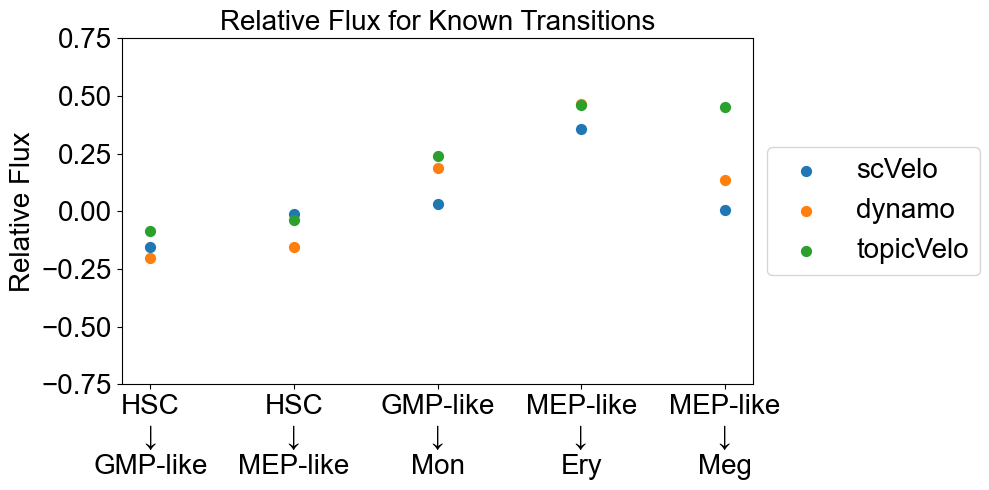

In [343]:
relative_flux_plot(adata,['scvelo_stochastic_T', 'dynamo_T','topicVelo_T'], 
                   legends = ['scVelo', 'dynamo', 'topicVelo'],
                   title = 'Relative Flux for Known Transitions', ylim=[-0.75, 0.75])

In [315]:
adata.uns['dynamo_T_rel_flux']

{('HSC', 'GMP-like'): -0.20049877990471862,
 ('HSC', 'MEP-like'): -0.15611526424603056,
 ('GMP-like', 'Mon'): 0.18636483288425723,
 ('MEP-like', 'Ery'): 0.46458300939357716,
 ('MEP-like', 'Meg'): 0.1362432041802071}